In [1]:
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import time
import sys
import os

import seaborn as sns
import matplotlib.dates as mdates
from datetime import datetime, date

# preamble for jupyter notebook and django
import django
import platform

if platform.node() == "srv-mcc-apsis":
    sys.path.append("/home/muef/tmv/BasicBrowser/")
    #sys.path.append('/home/leey/tmv/BasicBrowser/')
    dtm_path = "/home/galm/software/dtm/dtm/main"
else:
    # local paths
    sys.path.append('/media/Data/MCC/tmv/BasicBrowser/')
    dtm_path = "/home/finn/dtm/dtm/main"

os.environ.setdefault("DJANGO_SETTINGS_MODULE", "BasicBrowser.settings")
django.setup()

# import from appended path
import parliament.models as pm
import scoping.models as sm
from parliament.tasks import do_search, run_tm, combine_searches
import cities.models as cmodels
from django.contrib.auth.models import User
from tmv_app.models import * 
from utils.tm_mgmt import update_topic_scores
from django.db.models import Q, Count, Func, F, Sum, Avg, Value as V
from django.db.models.functions import TruncDate, TruncMonth, TruncYear

In [182]:
topic_id = 167079
topic_id = 167075 # energy transition 2
#topic_id = 167083 # energy transition
topic_id = 167076 # economy and jobs
topic_id = 167089 # climate policy

no_topwords = 10
topic = Topic.objects.get(pk=topic_id)
stat = topic.run_id
run_id = topic.run_id.pk

tterms = []
tts = TopicTerm.objects.filter(topic=topic)
tdts = TopicTimePeriodScores.objects.filter(
    topic=topic
).order_by('period__n')
for i, p in enumerate(stat.periods.all().order_by('n')):
    ytts = tts.filter(
        PY=p.n
    ).order_by('-score')[:no_topwords].select_related('term')
    top_terms = [topicterm.term.title for topicterm in ytts]
    #tdt = tdts[i]
    try:
        tdt = tdts.get(period=p)
        tdt.share = tdt.share*100
    except:
        print("failed to retrieve share")
        tdt = None
    tterms_dict = {#"score": tdt.score,
        "share": tdt.share,
        "period": p.parlperiod.n}
    for j, term in enumerate(top_terms):
        tterms_dict[j+1] = term
    tterms.append(tterms_dict)
    
df = pd.DataFrame(data=tterms).set_index('period')
df = df.transpose()

df
#for i in df.index:
#    print("{}: {}".format(df['period'][i], df['top_terms'][i]))

period,13,14,15,16,17,18,19
share,0.710628,2.02958,2.73374,12.0225,6.80781,8.56443,1.68965
1,klimaschutz,klimaschutz,klimaschutz,klimaschutz,klimaschutz,klimaschutz,klimaschutz
2,emissionshandel,emissionshandel,emissionshandel,emissionshandel,emissionshandel,emissionshandel,emissionshandel
3,prozent,prozent,prozent,prozent,kohlekraftwerk,bundesregier,bundesregier
4,bundesregier,bundesregier,bundesregier,bundesregier,prozent,prozent,prozent
5,instrument,instrument,kohlekraftwerk,kohlekraftwerk,bundesregier,kohlekraftwerk,kohlekraftwerk
6,kohlekraftwerk,kohlekraftwerk,deutschland,deutschland,deutschland,deutschland,deutschland
7,deutschland,deutschland,instrument,ziel,ziel,ziel,ziel
8,ziel,ziel,ziel,gabriel,gabriel,gabriel,erreich
9,minist,minist,minist,instrument,erreich,erreich,gabriel


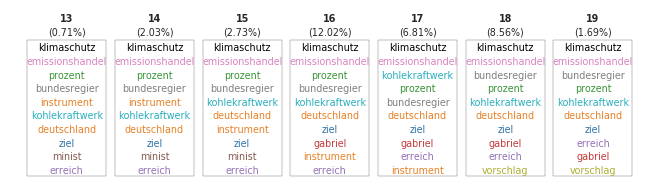

In [183]:
import matplotlib.patches as patches

sns.set()
sns.set_context('paper')
fig, ax = plt.subplots(figsize = (len(df.index)*1., no_topwords * 0.3))

# build color dict:
topword_list = [i for i in df.drop("share").values]
topword_set = set(np.array(topword_list).flatten())

#palette = sns.color_palette('husl', len(topword_set))
palette = sns.color_palette("tab10", n_colors=len(topword_set), desat=0.8)
#palette = sns.color_palette('dark', n_colors=len(topword_set))
palette[10] = (0, 0, 0)

# cmaps['Qualitative'] = ['Pastel1', 'Pastel2', 'Paired', 'Accent', 'Dark2', 'Set1', 'Set2', 'Set3', 'tab10', 'tab20', 'tab20b', 'tab20c']
color_dict = {topword: palette[i] for i, topword in enumerate(topword_set)}
#sns.palplot(palette)

for i, column in enumerate(df.columns):
    share = df[column]["share"]
    ax.text(i + 0.5, no_topwords + 1.2, column, weight='bold', horizontalalignment='center')
    ax.text(i + 0.5, no_topwords + 0.2, "({0:.2f}%)".format(share), horizontalalignment='center')

    for j, word in enumerate(df[column]):
        if isinstance(word, float):
            pass
        else:
            ax.text(i+0.5, no_topwords - j, word, horizontalalignment='center', color=color_dict[word])
    
    p = patches.Rectangle(
        (i+0.05, -0.2), 0.9, no_topwords,
        fill=False, #transform=ax.transAxes,
        clip_on=False
        )
    ax.add_patch(p)

ax.set_ylim([0, no_topwords + 2])
ax.set_xlim([0, len(df.columns)])

ax.axis('off')

plt.savefig('./plots/topic_analysis/topic_top_words_{}.png'.format(topic_id), dpi=300, bbox_inches="tight")

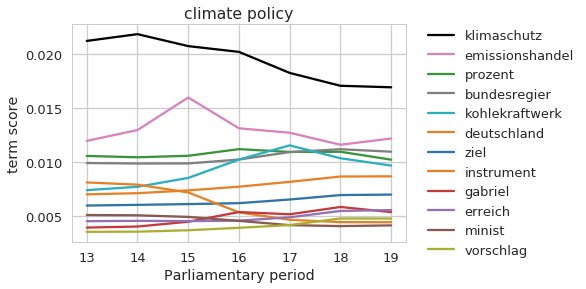

In [184]:
# plot word scores in the same colors
sns.set_context("talk")
sns.set_style('whitegrid')

terms = Term.objects.filter(topicterm__topic=topic).values('title').annotate(
summed_score = Sum(F('topicterm__score'))).order_by('-summed_score')[:20]

topicterm_list = [t['title'] for t in terms if t['title'] in topword_set]

sdf = pd.DataFrame(columns=df.columns, index=topicterm_list)

for topicterm in topicterm_list:
    for i, p in enumerate(stat.periods.all().order_by('n')):
        score = TopicTerm.objects.get(topic=topic, PY=p.n, term__title=topicterm).score
        sdf[p.parlperiod.n][topicterm] = score

sdf

fig, ax = plt.subplots()

for i in sdf.index:
    ax.plot(sdf.columns, sdf.loc[i], label=i, color=color_dict[i])
    
    # for smoothing
    #from scipy.ndimage.filters import gaussian_filter1d
    #ysmoothed = gaussian_filter1d(y, sigma=2)
    #plt.plot(x, ysmoothed)
    #plt.show()

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel('Parliamentary period')
plt.ylabel('term score')
plt.title(topic.title)

plt.savefig('./plots/topic_analysis/topic_term_scores_{}_{}.png'.format(topic.title, topic_id), dpi=300, bbox_inches="tight")

{'score__sum': 3.58306462718893}
{'score__sum': 0.510003611552585}
{'score__count': 221}


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff43ce87128>]],
      dtype=object)

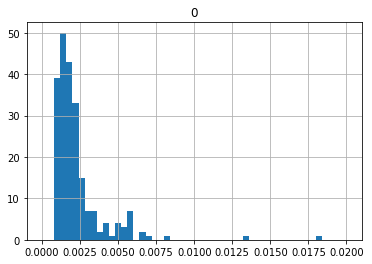

In [155]:
print(TopicTerm.objects.filter(topic=topic).aggregate(Sum('score')))
print(TopicTerm.objects.filter(topic=topic, PY=1).aggregate(Sum('score')))
print(TopicTerm.objects.filter(topic=topic, PY=1).aggregate(Count('score')))

df_termscores = pd.DataFrame.from_dict(TopicTerm.objects.filter(topic=topic, PY=1).values_list('score'))
df_termscores.hist(bins=50, range=(0, 0.02))